In [1]:
import mitsuba as mi
import drjit as dr 
import matplotlib.pyplot as plt
mi.set_variant("cuda_ad_rgb")

In [2]:
## get LED position P_LED and Direction D_LED ##
N_LED = 24
LED0_pos = mi.Point3f(-34.41,0,-12.5)
angle = 2*dr.pi/N_LED*dr.arange(mi.Float,N_LED)
Q = dr.rotate(mi.Quaternion4f,mi.Vector3f(0, 0, 1),angle)
P_LED = dr.quat_to_matrix(Q, 3)@LED0_pos

D_LED = -P_LED
D_LED.z = 0
D_LED = dr.normalize(D_LED)

In [3]:
## get LED intensity ##
A = 0.4
B = 0.5

i_list = dr.arange(mi.Float,N_LED)

S = mi.TensorXf(0,[1,N_LED,3])

S[:,:,0] = A*dr.sin(2*dr.pi/N_LED*i_list)+B
S[:,:,1] = A*dr.sin(2*dr.pi/N_LED*(i_list-N_LED/3))+B
S[:,:,2] = A*dr.sin(2*dr.pi/N_LED*(i_list+N_LED/3))+B

In [4]:
### Image pixel resolution ###
image_res = (256, 256)
### camera origin          ###
cam_origin = mi.Point3f(0,0,-50)
### camera fov in mm       ###
cam_fov = (70,70)

import utils.camera 
cam = utils.camera.Camera(cam_origin, image_res,cam_fov)

### compute the surface interactions ###


In [5]:
import time


start_time = time.time()
scene = mi.load_file('../scenes/iristac_ply.xml')

si = cam.shot(scene)

# compute incident direction D_incident
P_LED_t = mi.TensorXf(dr.ravel(P_LED),shape=[1,N_LED,3])
N_Pixel = image_res[0]*image_res[1]
P_Pixel_t = mi.TensorXf(dr.ravel(si.p),shape=[N_Pixel,1,3])
norm_Pixel = dr.select(si.is_valid(),si.n,0)
norm_Pixel_t = mi.TensorXf(dr.ravel(norm_Pixel),shape=[N_Pixel,1,3])
D_incident = P_Pixel_t - P_LED_t
D_incident_n = mi.TensorXf(dr.block_sum(dr.sqr(D_incident.array),3),shape=[N_Pixel,N_LED,1])
D_incident = D_incident/dr.sqrt(D_incident_n)

# compute angle between incident and Surface normal
cosine1 = D_incident*norm_Pixel_t
cosine1 = mi.TensorXf(dr.block_sum(cosine1.array,3),shape=[N_Pixel,N_LED,1])
cosine1 = dr.select(cosine1>0,cosine1,0)

# compute angle between incident and LED normal
D_LED_t = mi.TensorXf(dr.ravel(D_LED),shape=[1,N_LED,3])
cosine2 = D_incident*D_LED_t
cosine2 = mi.TensorXf(dr.block_sum(cosine2.array,3),shape=[N_Pixel,N_LED,1])
cosine2 = dr.select(cosine2>0,cosine2,0)

### Exclude rays that are blocked by surface ###
ray_test_o = P_Pixel_t - mi.TensorXf(0,shape=[1,N_LED,3])
ray_test_o[:,:,2] = ray_test_o[:,:,2].array-10*dr.epsilon(mi.Float)
id_test = dr.arange(mi.UInt,N_Pixel*N_LED)
ray_test_o = dr.gather(mi.Point3f, ray_test_o.array, id_test)
ray_test_d = dr.gather(mi.Vector3f, -D_incident.array, id_test)
ray_test =  mi.Ray3f(o=ray_test_o,d=ray_test_d)
ray_test_result = scene.ray_test(ray_test)
cosine1 = dr.select(mi.TensorXb(~ray_test_result,[N_Pixel,N_LED,1]),cosine1,0)

# compute intensity of incident with each color
I_inc = cosine2*S

# compute intensity of diffuse reflection on each pixel for each LED with each color
I_diff = I_inc*cosine1

# compute image RGB value
I_RGB = mi.TensorXf(0,shape=[image_res[0],image_res[1],3])
k_r,k_g,k_b = 0.2,0.2,0.2
K = [k_r,k_g,k_b]

for i in range(3):
    I_RGB[:,:,i] = dr.block_sum(I_diff[:,:,i].array,N_LED)*K[i]

end_time = time.time()
print("Time used: {:.10f} seconds".format(end_time - start_time))

Time used: 0.0757353306 seconds


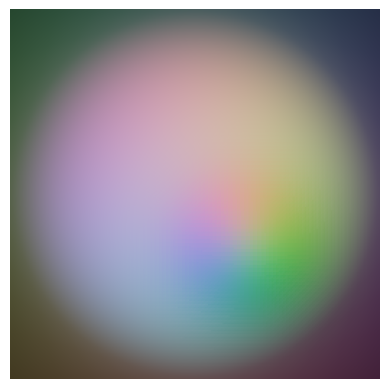

In [6]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(I_RGB)
plt.show()

In [7]:
bmp = mi.Bitmap(I_RGB)
bmp = bmp.convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.UInt8, False)
bmp.write('../scenes/img/normal-10-10.png')